In [1]:
%matplotlib inline

In [2]:
import numpy as np
import networkx as nx
import seaborn as sns


from numpy.linalg import eigh
from helpers import signed_layout, draw_nodes, draw_edges, flatten, get_lcc, signed_laplacian, signed_conductance
from scipy.sparse import issparse
from matplotlib import pyplot as plt
from collections import defaultdict

from sklearn.cluster import KMeans

In [29]:
path = 'graphs/congress.pkl'
use_heuristic_position = False

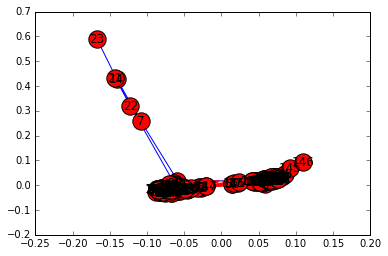

In [30]:
g = nx.read_gpickle(path)

A = nx.adj_matrix(g, weight='sign').todense()

if use_heuristic_position:
    alpha = 1
    g_for_pos = g.copy()
    for u, v in g.edges():
        g_for_pos[u][v]['weight'] = np.exp(alpha * g[u][v]['sign'])
    pos = nx.spring_layout(g_for_pos, weight='weight')
else:
    pos = signed_layout(g)

draw_nodes(g, pos)
# nx.draw_networkx_nodes(g, pos, node_size=100)
draw_edges(g, pos)

In [31]:
if False:
    g = nx.Graph()
    edges_with_sign = [
        (0, 1, 1),
        (0, 2, -1), (1, 2, -1),
        (0, 3, 1), (1, 3, 1)
    ]
    for u, v, s in edges_with_sign:
        g.add_edge(u, v, sign=s)

    # pos = signed_layout(g)
    pos = {0: [1, 1], 1: [1, 0], 2: [2, 0.5], 3: [0, 0.5]}
    draw_nodes(g, pos)
    draw_edges(g, pos)  

    A = nx.adj_matrix(g, weight='sign').todense()
    A = np.asarray(A)
    A

In [32]:
# path a ---(+)--- b ---(-)--- c
C1 = (A @ A)
C1[C1 >= 0] = 0

C2 = A.copy()
C2[C2>0] = 0
pos_neg_C = C1 * C2

# path a ---(-)--- b ---(-)--- c
neg_A = A.copy()
neg_A[neg_A > 0] = 0
C1 = (neg_A @ neg_A)
C1[C1 < 0] = 0

C2 = A.copy()
C2[C2<0] = 0

neg_neg_C = C1 * C2
W = pos_neg_C + neg_neg_C

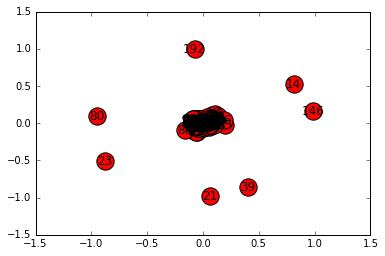

In [33]:
g_motif = nx.from_numpy_array(W)
nx.draw_networkx(g_motif)

In [34]:
def normlized_laplacian(A):
    if issparse(A):
        A = np.asarray(A.todense())
        deg = A.sum(axis=0)
        D_neg_half = np.diag(flatten(1 / np.sqrt(deg)))
        L_norm = np.eye(A.shape[0]) - D_neg_half.dot(A).dot(D_neg_half)
        return L_norm

def signed_normlized_laplacian(A):
    if issparse(A):
        A = np.asarray(A.todense())
    deg = np.abs(A).sum(axis=0)
    D_neg_half = np.diag(flatten(1 / np.sqrt(deg)))

    L_norm = np.eye(A.shape[0]) - D_neg_half.dot(A).dot(D_neg_half)
    return L_norm
    
def conductance(g, S, weight=None, verbose=False):
    numer = 0
    denum = 0
    S = set(S)
    vol = sum(d for _, d in g.degree(weight='weight'))
    for u in S:
        for v in g.neighbors(u):
            w = g[u][v].get('weight', 1)
            if v not in S:                
                numer += w
            denum += w
    denum = min(denum,  vol - denum)
    if verbose >= 1:
        print('{} / {}'.format(numer, denum))
    return numer / denum

def dict2array(d):
    a = np.zeros(len(d), dtype=float)
    for i, v in d.items():
        a[i] = v
    return a

def signed_group_conductance(g, groups, verbose=0):
    """
    fraction of edges from nodes S that are either + outside or - inside

    |cut+(S, V\S) + #deg-(S)| / sum_s deg(s)
    """
    numer_sum = 0
    denum_sum = 0
    for S in groups:
        numer = 0
        denum = 0
        S = set(S)
        for u in S:
            for v in g.neighbors(u):
                if v in S and g[u][v]['sign'] == -1:
                    numer += 1
                elif v not in S and g[u][v]['sign'] == 1:
                    numer += 1
                denum += 1
        if verbose >= 1:
            print('{} / {}'.format(numer, denum))
        denum = min(denum, 2 * g.number_of_edges() - denum)
        numer_sum += numer
        denum_sum += denum
    if verbose >= 1:
        print('total: {} / {}'.format(numer_sum, denum_sum))

    return numer_sum / denum_sum

lcc has 212 nodes (g has 219 nodes)
get node score
sweeping
best position 210
community [85, 86, 56, 63, 58, 43, 200, 139, 218, 217, 94, 113, 199, 72, 65, 92, 70, 141, 211, 195, 118, 193, 83, 152, 160, 158, 157, 156, 162, 151, 149, 163, 145, 84, 110, 25, 40, 150, 180, 143, 26, 153, 173, 130, 132, 134, 185, 136, 45, 111, 112, 159, 82, 66, 179, 177, 176, 138, 44, 42, 183, 154, 194, 15, 20, 87, 161, 187, 125, 174, 142, 201, 181, 137, 73, 147, 57, 24, 17, 67, 61, 38, 208, 69, 93, 71, 53, 91, 62, 6, 184, 59, 4, 0, 18, 140, 1, 196, 115, 123, 50, 54, 55, 144, 117, 52, 3, 2, 68, 30, 90, 182, 5, 120, 124, 129, 49, 11, 203, 98, 16, 101, 9, 148, 191, 41, 128, 198, 13, 127, 165, 121, 33, 8, 89, 126, 169, 131, 36, 213, 48, 133, 164, 37, 109, 79, 155, 27, 19, 96, 97, 105, 104, 108, 114, 189, 106, 188, 99, 64, 60, 46, 190, 28, 75, 107, 116, 103, 47, 95, 122, 81, 22, 74, 186, 119, 172, 178, 76, 10, 12, 135, 78, 204, 35, 166, 170, 77, 171, 167, 168, 7, 205, 209, 210, 202, 34, 175, 197, 206, 207, 212, 2

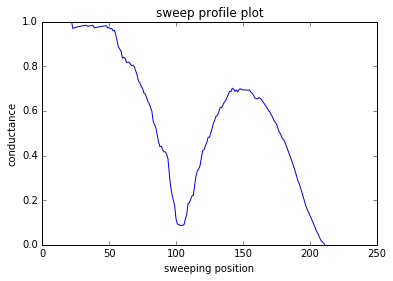

In [35]:
lcc = get_lcc(g_motif)

node_lcc2g = {}
node_g2lcc = {}
for lcc_u, g_u in enumerate(lcc.nodes()):
    node_lcc2g[lcc_u] = g_u
    node_g2lcc[g_u] = lcc_u
    
lcc = nx.relabel_nodes(lcc, mapping=node_g2lcc, copy=True)

print('lcc has {} nodes (g has {} nodes)'.format(lcc.number_of_nodes(), g.number_of_nodes()))
L_n = normlized_laplacian(nx.adj_matrix(lcc))

print('get node score')
eigval, eigvec = eigh(L_n)
z_vect = eigvec[:, 1]

deg = lcc.degree(weight='weight')
deg = dict2array(dict(deg))

node_scores = z_vect / deg

print('sweeping')
order = np.argsort(node_scores)[::-1]
sweep_positions = []
sweep_scores = []
for i in range(1, len(order)):  # omit the last entry
    sweep_positions.append(i)
    s = conductance(lcc, order[:i])
    sweep_scores.append(s)
    
    
fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores)
ax.set_title('sweep profile plot')
ax.set_xlabel('sweeping position')
ax.set_ylabel('conductance')

# get the best community
best_pos = np.argmin(sweep_scores)
comm = order[:best_pos+1]
print('best position', best_pos)

# map back the lcc nodes to g
comm = [node_lcc2g[n] for n in comm]
print('community', comm)    


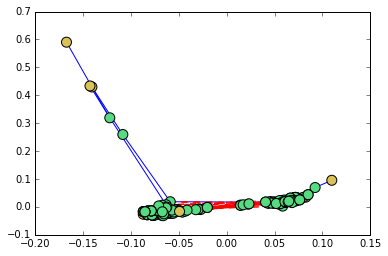

In [36]:
pal = sns.color_palette('hls', 8)
# sns.palplot(pal)

node_color = np.zeros((g.number_of_nodes(), 3))
for i in np.arange(g.number_of_nodes()):
    if i in comm:
        node_color[i] = pal[3]
    else:
        node_color[i] = pal[1]
    
    
nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=100)
# nx.draw_networkx_labels(g, pos, labels=None)

draw_edges(g, pos)

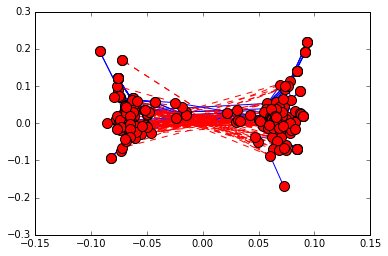

In [37]:
subg = g.subgraph(comm)
subg = nx.convert_node_labels_to_integers(subg)
subg_pos = signed_layout(subg)

# draw_nodes(subg, subg_pos)
nx.draw_networkx_nodes(subg, subg_pos, node_size=100)
draw_edges(subg, subg_pos)

In [38]:
A = nx.adj_matrix(subg, weight='sign')
if issparse(A):
    A = np.asarray(A.todense())
deg = np.abs(A).sum(axis=0)
D_neg_half = np.diag(flatten(1 / np.sqrt(deg)))

L_norm = np.eye(A.shape[0]) - D_neg_half.dot(A).dot(D_neg_half)


In [39]:
L_subg = signed_normlized_laplacian(nx.adj_matrix(subg, weight='sign'))

In [40]:
eig_vals, eig_vects = eigh(L_subg)


ks = [2, 3, 4, 5, 6, 7]
avg_phi_list = []
for k in ks:
    embedding = eig_vects[:, :k]  # top-k eigen vectors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding)
    labels = kmeans.labels_
    groups = defaultdict(list)    
    for i, l in enumerate(labels):
        groups[l].append(i)
    avg_phi_list.append(signed_group_conductance(subg, groups.values()))
best_k = ks[np.argmin(avg_phi_list)]    
for phi in avg_phi_list:
    print(phi)
print('best k', best_k)

0.03578528827037773
0.11545988258317025
0.17416829745596868
0.20939334637964774
0.19373776908023482
0.3111545988258317
best k 2


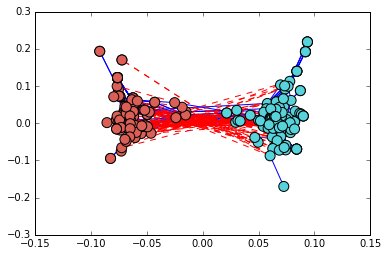

In [41]:
pal = sns.color_palette('hls', best_k)
embedding = eig_vects[:, :best_k]  # top-k eigen vectors
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(embedding)
node_color = np.zeros((subg.number_of_nodes(), 3))
for i in np.arange(subg.number_of_nodes()):
    node_color[i] = pal[kmeans.labels_[i]]

# draw_nodes(subg, subg_pos)
nx.draw_networkx_nodes(subg, subg_pos, node_size=100, node_color=node_color)
draw_edges(subg, subg_pos)